# Interactive Exploration Notebook

Explore:
- Trades (including open trades)
- Rule scores
- Rule stability
- Sector investability
- Portfolio equity
- Per-rule trade distributions
- Interactive rule selector
- Interactive sector selector
- Parameter explorer
- Open-trade visualizer
- Portfolio timeline with open-trade overlays

All powered by `ipywidgets`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display

plt.style.use('seaborn-v0_8')

BASE = Path('..').resolve()
research_dir = BASE / 'research'

# Core engine outputs
trades = pd.read_csv(
    research_dir / 'all_trades_with_rule_id.csv',
    parse_dates=['signal_date','entry_date','exit_date']
)

rules = pd.read_csv(research_dir / 'rule_scores.csv')
stability = pd.read_csv(research_dir / 'rule_stability.csv')
sectors = pd.read_csv(research_dir / 'sector_investability.csv')

equity = pd.read_csv(
    research_dir / 'portfolio_equity_curve.csv',
    index_col=0,
    parse_dates=True
)

used_trades = pd.read_csv(
    research_dir / 'portfolio_used_trades.csv',
    parse_dates=['signal_date','entry_date','exit_date']
)

# Ensure is_open exists (for older runs)
if 'is_open' not in trades.columns:
    trades['is_open'] = trades['exit_date'].isna()

trades.head()

,group,ticker,direction,signal_date,entry_date,exit_date,entry_lag,hold_days,lookback,group_thresh,participation,lagger_max_move,ret,leaders,is_open,rule_id,rule_quality_score
0,CHEMICALS_1,CE,-1,2025-01-31,2025-01-31,2025-02-05,0,3,2,0.015,0.5,0.01125,0.015484,"DOW,HUN,WLK,LYB,OLN",False,R_6BDD8542,0.026946
1,CHEMICALS_1,CE,-1,2025-01-31,2025-01-31,2025-02-07,0,5,2,0.015,0.5,0.01125,0.042089,"DOW,HUN,WLK,LYB,OLN",False,R_57B4E805,0.037696
2,CHEMICALS_1,CE,-1,2025-01-31,2025-01-31,2025-02-11,0,7,2,0.015,0.5,0.01125,0.059544,"DOW,HUN,WLK,LYB,OLN",False,R_E59F9259,0.046843
3,CHEMICALS_1,CE,-1,2025-01-31,2025-01-31,2025-02-14,0,10,2,0.015,0.5,0.01125,0.041948,"DOW,HUN,WLK,LYB,OLN",False,R_F01A4A51,0.049666
4,CHEMICALS_1,CE,-1,2025-01-31,2025-02-03,2025-02-06,1,3,2,0.015,0.5,0.01125,-0.001745,"DOW,HUN,WLK,LYB,OLN",False,R_585D7262,0.004397


## Portfolio Equity Curve Viewer

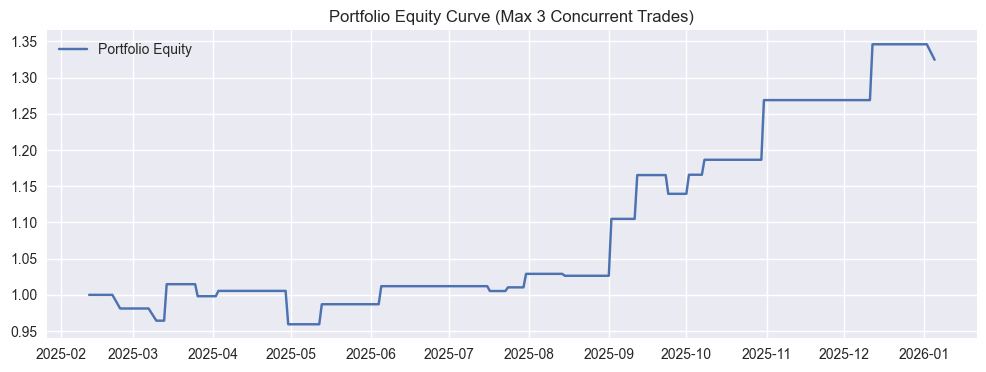

In [2]:
def plot_equity():
    plt.figure(figsize=(12,4))
    plt.plot(equity, label='Portfolio Equity')
    plt.title('Portfolio Equity Curve (Max 3 Concurrent Trades)')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_equity()

## Interactive Rule Selector

Pick a rule and explore its trades, return distribution, and sector breakdown.

In [18]:
rule_dropdown = widgets.Dropdown(
    options=[
        (f"{row.rule_id} — win {row.win_rate:.2%}, avg {row.avg_ret_full:.2%}", i)
        for i, row in rules.iterrows()
    ],
    description='Rule:',
    layout=widgets.Layout(width='600px')
)

def show_rule(idx):
    row = rules.iloc[idx]

    # Correct filtering: use rule_id, not parameters
    df = trades[trades.rule_id == row.rule_id]

    closed = df[df.exit_date.notna()]

    print(f"Rule ID: {row.rule_id}")
    print(f"Total trades: {len(df)}")
    print(f"Closed trades: {len(closed)}")
    print(f"Win rate (closed only): {closed.ret.gt(0).mean():.2%}")
    print(f"Avg return (closed only): {closed.ret.mean():.2%}")

    if len(closed) > 0:
        plt.figure(figsize=(10,4))
        closed.ret.hist(bins=30)
        plt.title(f"Return Distribution — {row.rule_id}")
        plt.show()

    sector_stats = df.groupby('group').ret.mean().sort_values(ascending=False)
    display(sector_stats)

widgets.interact(show_rule, idx=rule_dropdown)

interactive(children=(Dropdown(description='Rule:', layout=Layout(width='600px'), options=(('R_6BDD8542 — win …

<function __main__.show_rule(idx)>

## Interactive Sector Selector

Explore trades and performance for any sector.

In [5]:
sector_dropdown = widgets.Dropdown(
    options=sorted(trades.group.unique()),
    description='Sector:',
    layout=widgets.Layout(width='400px')
)

def show_sector(sector):
    df = trades[trades.group == sector]
    closed = df[df.exit_date.notna()]

    print(f"Trades in {sector}: {len(df)}")
    print(f"Closed trades: {len(closed)}")
    print(f"Win rate: {closed.ret.gt(0).mean():.2%}")
    print(f"Avg return: {closed.ret.mean():.2%}")

    if len(closed) > 0:
        plt.figure(figsize=(10,4))
        closed.ret.hist(bins=30)
        plt.title(f'Return Distribution — {sector}')
        plt.show()

widgets.interact(show_sector, sector=sector_dropdown)

interactive(children=(Dropdown(description='Sector:', layout=Layout(width='400px'), options=('AG_EQUIP', 'BANK…

<function __main__.show_sector(sector)>

## Interactive Trade Browser

Scroll through trades by ticker (open trades included).

In [7]:
ticker_dropdown = widgets.Dropdown(
    options=sorted(trades.ticker.unique()),
    description='Ticker:',
    layout=widgets.Layout(width='300px')
)

def browse_trades(ticker):
    df = trades[trades.ticker == ticker].sort_values('entry_date')
    display(df.head(50))

widgets.interact(browse_trades, ticker=ticker_dropdown)

interactive(children=(Dropdown(description='Ticker:', layout=Layout(width='300px'), options=('ABBV', 'ADBE', '…

<function __main__.browse_trades(ticker)>

## Parameter Explorer

Filter trades by rule parameters interactively.

In [9]:
lookback_slider = widgets.SelectionSlider(
    options=sorted(trades.lookback.unique()),
    description='Lookback:',
    continuous_update=False
)

entry_slider = widgets.SelectionSlider(
    options=sorted(trades.entry_lag.unique()),
    description='Entry lag:',
    continuous_update=False
)

hold_slider = widgets.SelectionSlider(
    options=sorted(trades.hold_days.unique()),
    description='Hold days:',
    continuous_update=False
)

def explore_params(lookback, entry_lag, hold_days):
    df = trades[
        (trades.lookback == lookback) &
        (trades.entry_lag == entry_lag) &
        (trades.hold_days == hold_days)
    ]

    closed = df[df.exit_date.notna()]

    print(f"Trades: {len(df)}")
    print(f"Closed trades: {len(closed)}")
    print(f"Win rate: {closed.ret.gt(0).mean():.2%}")
    print(f"Avg return: {closed.ret.mean():.2%}")

    if len(closed) > 0:
        plt.figure(figsize=(10,4))
        closed.ret.hist(bins=30)
        plt.title('Return Distribution')
        plt.show()

widgets.interact(explore_params, lookback=lookback_slider, entry_lag=entry_slider, hold_days=hold_slider)

interactive(children=(SelectionSlider(continuous_update=False, description='Lookback:', options=(np.int64(2), …

<function __main__.explore_params(lookback, entry_lag, hold_days)>

## Open-Trade Visualizer

See where open trades are, by sector and ticker, and how many are currently open.

Total open trades: 42582

Open trades by sector:


group
BANKING_2           7020
TECH_HARDWARE       4572
FOOD_1              4056
BANKING_3           3624
CHEMICALS_1         3328
AG_EQUIP            2496
MEDS_1              2478
OIL_ENERGY          2472
INDUSTRIALS_ELEC    1968
SEMIS_EQUIP         1692
GOLD_SILVER_1       1644
BANKING_4           1584
SW_SOFTWARE_1       1320
GOLD_SILVER_2       1220
MIDSTREAM_1         1032
BANKING_1            948
BASE_METALS          768
TELECOM              360
dtype: int64


Top 20 tickers by open trades:


ticker
USB     2544
TFC     2478
BAC     2268
AGCO    2136
SMH     2124
ITT     1704
KHC     1668
GIS     1620
SCHW    1554
RF      1488
NVDA    1476
V       1416
CDNS    1320
MRK     1248
EPM     1152
LNG     1032
FNV      924
CE       880
TER      872
COP      852
dtype: int64

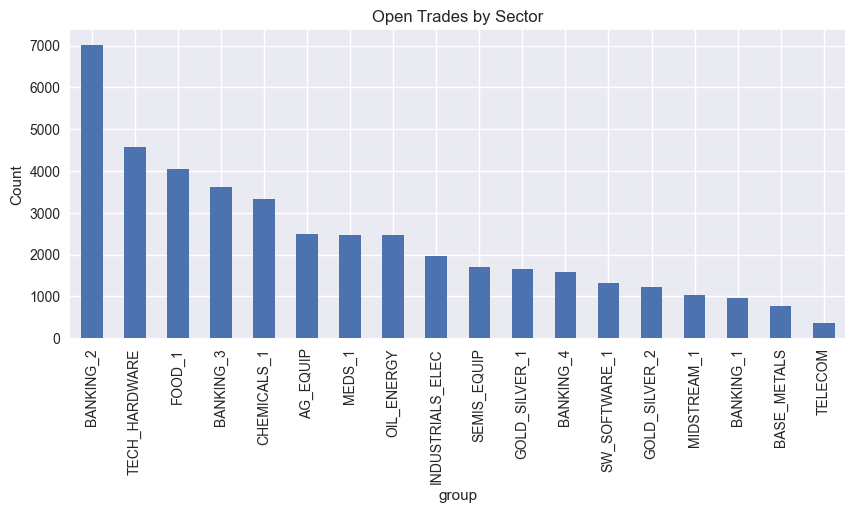

In [10]:
def summarize_open_trades():
    open_df = trades[trades['exit_date'].isna()].copy()
    if open_df.empty:
        print("No open trades.")
        return

    print(f"Total open trades: {len(open_df)}")
    by_sector = open_df.groupby('group').size().sort_values(ascending=False)
    print("\nOpen trades by sector:")
    display(by_sector)

    by_ticker = open_df.groupby('ticker').size().sort_values(ascending=False).head(20)
    print("\nTop 20 tickers by open trades:")
    display(by_ticker)

    plt.figure(figsize=(10,4))
    by_sector.plot(kind='bar')
    plt.title('Open Trades by Sector')
    plt.ylabel('Count')
    plt.grid(True, axis='y')
    plt.show()

summarize_open_trades()

### Interactive Open-Trade Browser

Filter open trades by sector and ticker.

In [12]:
open_trades = trades[trades['exit_date'].isna()].copy()

if open_trades.empty:
    print("No open trades to browse.")
else:
    open_sector_dropdown = widgets.Dropdown(
        options=['(all)'] + sorted(open_trades.group.unique().tolist()),
        description='Sector:',
        layout=widgets.Layout(width='300px')
    )

    def update_ticker_options(sector):
        if sector == '(all)':
            return sorted(open_trades.ticker.unique().tolist())
        return sorted(open_trades[open_trades.group == sector].ticker.unique().tolist())

    ticker_dropdown = widgets.Dropdown(
        options=update_ticker_options('(all)'),
        description='Ticker:',
        layout=widgets.Layout(width='300px')
    )

    def on_sector_change(change):
        if change['name'] == 'value':
            ticker_dropdown.options = update_ticker_options(change['new'])

    open_sector_dropdown.observe(on_sector_change)

    def browse_open(sector, ticker):
        df = open_trades.copy()
        if sector != '(all)':
            df = df[df.group == sector]
        if ticker is not None:
            df = df[df.ticker == ticker]
        df = df.sort_values('entry_date')
        display(df.head(50))

    ui = widgets.HBox([open_sector_dropdown, ticker_dropdown])
    out = widgets.interactive_output(browse_open, {'sector': open_sector_dropdown, 'ticker': ticker_dropdown})
    display(ui, out)

Output()

## Rule Stability Explorer

Inspect rule stability metrics: full-period, last 90 days, last 30 days, and investable flag.

In [14]:
if not stability.empty:
    # Ensure expected columns exist
    for col in ['avg_ret_full','avg_ret_prev_90d','avg_ret_prev_30d','win_rate','max_dd']:
        if col in stability.columns:
            stability[col] = stability[col].astype(float)

    stab_rule_dropdown = widgets.Dropdown(
        options=[
            (f"{row.rule_id} — {row.group}", i)
            for i, row in stability.iterrows()
        ],
        description='Rule:',
        layout=widgets.Layout(width='400px')
    )

    def show_stability(idx):
        row = stability.iloc[idx]
        print(f"Rule ID: {row.rule_id}")
        print(f"Sector: {row.group}")
        print(f"Investable: {bool(row.get('is_investable', False))}")
        print(f"Trades: {int(row.n_trades)}")
        print(f"Avg ret (full): {row.avg_ret_full:.2%}")
        print(f"Avg ret (prev 90d): {row.avg_ret_prev_90d:.2%}")
        print(f"Avg ret (prev 30d): {row.avg_ret_prev_30d:.2%}")
        print(f"Win rate: {row.win_rate:.2%}")
        print(f"Max drawdown (trade-level): {row.max_dd:.2%}")

    widgets.interact(show_stability, idx=stab_rule_dropdown)
else:
    print("No rule stability data available.")

interactive(children=(Dropdown(description='Rule:', layout=Layout(width='400px'), options=(('R_6BDD8542 — CHEM…

## Sector Investability Explorer

Inspect sector-level performance and investability metrics.

In [16]:
if not sectors.empty:
    sector_inv_dropdown = widgets.Dropdown(
        options=sorted(sectors.group.unique()),
        description='Sector:',
        layout=widgets.Layout(width='300px')
    )

    def show_sector_inv(sector):
        row = sectors[sectors.group == sector].iloc[0]
        print(f"Sector: {row.group}")
        print(f"Mean ret: {row['mean']:.4%}")
        print(f"Win rate: {row['win_rate']:.2%}")
        print(f"Sharpe: {row['sharpe']:.3f}")
        print(f"Sortino: {row['sortino']:.3f}")
        print(f"Stability: {row['stability']:.3f}")

        df = trades[trades.group == sector]
        closed = df[df.exit_date.notna()]
        if len(closed) > 0:
            plt.figure(figsize=(10,4))
            closed.ret.hist(bins=30)
            plt.title(f'Return Distribution — {sector}')
            plt.show()

    widgets.interact(show_sector_inv, sector=sector_inv_dropdown)
else:
    print("No sector investability data available.")

interactive(children=(Dropdown(description='Sector:', layout=Layout(width='300px'), options=('AG_EQUIP', 'BANK…

## Portfolio Timeline with Open-Trade Overlays

Overlay open trades on top of the portfolio equity curve to see where risk is currently deployed.

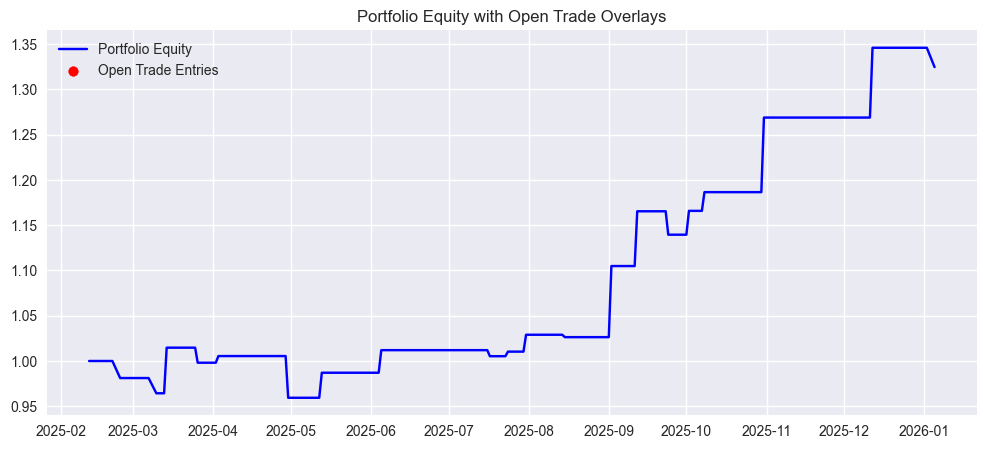

In [17]:
def plot_equity_with_open_trades():
    plt.figure(figsize=(12,5))
    plt.plot(equity.index, equity.values, label='Portfolio Equity', color='blue')

    open_df = trades[trades['exit_date'].isna()].copy()
    if not open_df.empty:
        # For each open trade, mark its entry date on the equity curve
        for _, tr in open_df.iterrows():
            entry_date = tr['entry_date']
            if entry_date in equity.index:
                plt.axvline(entry_date, color='orange', alpha=0.2)

        plt.scatter(
            [d for d in open_df['entry_date'] if d in equity.index],
            [equity.loc[d] for d in open_df['entry_date'] if d in equity.index],
            color='red',
            label='Open Trade Entries',
            zorder=5
        )

    plt.title('Portfolio Equity with Open Trade Overlays')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_equity_with_open_trades()

In [16]:
import ipywidgets as widgets 
widgets.Dropdown(options=['A','B','C'])

Dropdown(options=('A', 'B', 'C'), value='A')